# RoBERTa Optimizations: Robustly Optimized BERT Pretraining

**Rank**: #1 - Revolutionary Impact

## Background & Motivation

When BERT was first published in 2018, it set new state-of-the-art results across many NLP tasks. However, researchers at Facebook AI noticed that BERT might not have been trained optimally. The original BERT paper left many hyperparameters and training choices unexplored.

**The Problem**: BERT's training was:
- Undertrained (only 1M steps vs RoBERTa's 500K)
- Using static masking (same masks every epoch)
- Training with Next Sentence Prediction (NSP) task
- Using smaller batch sizes
- Not utilizing the full potential of the model

## What You'll Learn:
1. **Dynamic Masking**: Why changing masks improves learning
2. **Removing NSP**: Why this task hurts performance
3. **Large Batch Training**: The benefits of bigger batches
4. **Training Duration**: Why longer training helps
5. **Implementation**: How to implement these optimizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
from collections import defaultdict
sys.path.append('..')

np.random.seed(42)
random.seed(42)

# Set style for better visualizations
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid') 
    except OSError:
        plt.style.use('default')
        
print("RoBERTa: A Robustly Optimized BERT Pretraining Approach")
print("Paper: Liu et al., 2019 - Facebook AI Research")
print("Impact: Became the foundation for most modern BERT variants")

RoBERTa: A Robustly Optimized BERT Pretraining Approach
Paper: Liu et al., 2019 - Facebook AI Research
Impact: Became the foundation for most modern BERT variants


## Part 1: The Original Paper Context

### Paper Details
- **Title**: "RoBERTa: A Robustly Optimized BERT Pretraining Approach"
- **Authors**: Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov
- **Institution**: Facebook AI Research
- **Published**: July 2019
- **arXiv**: https://arxiv.org/abs/1907.11692

### Key Contributions
1. **Training longer** with bigger batches over more data
2. **Removing NSP task** (Next Sentence Prediction)
3. **Dynamic masking** instead of static masking
4. **Text encoding** with larger byte-pair encoding vocabulary

### Impact on the Field
RoBERTa's optimizations became standard practice:
- **DeBERTa** (2020): Built directly on RoBERTa principles
- **ELECTRA** (2020): Used RoBERTa training setup
- **SpanBERT** (2019): Adopted dynamic masking
- **ALBERT** (2019): Used longer training and larger batches

## Part 2: Dynamic vs Static Masking

**Static Masking (Original BERT)**: Mask tokens once during preprocessing, same masks every epoch
**Dynamic Masking (RoBERTa)**: Generate new masks for each training example every time it's seen

In [2]:
def static_masking_demo(text_tokens, mask_prob=0.15, num_epochs=5):
    """
    Demonstrate static masking - same masks every epoch
    """
    # Generate masks once (static)
    masks = np.random.rand(len(text_tokens)) < mask_prob
    
    print("STATIC MASKING (Original BERT):")
    print(f"Original: {text_tokens}")
    
    # Same masks every epoch
    for epoch in range(num_epochs):
        masked_tokens = text_tokens.copy()
        masked_tokens[masks] = '[MASK]'
        print(f"Epoch {epoch+1}: {masked_tokens}")
    
    return masks

def dynamic_masking_demo(text_tokens, mask_prob=0.15, num_epochs=5):
    """
    Demonstrate dynamic masking - different masks each epoch
    """
    print("\nDYNAMIC MASKING (RoBERTa):")
    print(f"Original: {text_tokens}")
    
    all_masks = []
    # Generate new masks every epoch
    for epoch in range(num_epochs):
        masks = np.random.rand(len(text_tokens)) < mask_prob
        masked_tokens = text_tokens.copy()
        masked_tokens[masks] = '[MASK]'
        print(f"Epoch {epoch+1}: {masked_tokens}")
        all_masks.append(masks)
    
    return all_masks

# Example sentence
sentence = np.array(['The', 'quick', 'brown', 'fox', 'jumps', 'over', 'lazy', 'dog'])

# Demonstrate both approaches
static_masks = static_masking_demo(sentence)
dynamic_masks = dynamic_masking_demo(sentence)

STATIC MASKING (Original BERT):
Original: ['The' 'quick' 'brown' 'fox' 'jumps' 'over' 'lazy' 'dog']
Epoch 1: ['The' 'quick' 'brown' 'fox' 'jumps' 'over' '[MASK' 'dog']
Epoch 2: ['The' 'quick' 'brown' 'fox' 'jumps' 'over' '[MASK' 'dog']
Epoch 3: ['The' 'quick' 'brown' 'fox' 'jumps' 'over' '[MASK' 'dog']
Epoch 4: ['The' 'quick' 'brown' 'fox' 'jumps' 'over' '[MASK' 'dog']
Epoch 5: ['The' 'quick' 'brown' 'fox' 'jumps' 'over' '[MASK' 'dog']

DYNAMIC MASKING (RoBERTa):
Original: ['The' 'quick' 'brown' 'fox' 'jumps' 'over' 'lazy' 'dog']
Epoch 1: ['The' 'quick' '[MASK' 'fox' 'jumps' 'over' 'lazy' 'dog']
Epoch 2: ['The' 'quick' 'brown' 'fox' 'jumps' '[MASK' 'lazy' 'dog']
Epoch 3: ['The' 'quick' 'brown' 'fox' 'jumps' '[MASK' 'lazy' 'dog']
Epoch 4: ['[MASK' 'quick' 'brown' 'fox' 'jumps' '[MASK' 'lazy' 'dog']
Epoch 5: ['[MASK' 'quick' '[MASK' 'fox' 'jumps' 'over' 'lazy' 'dog']


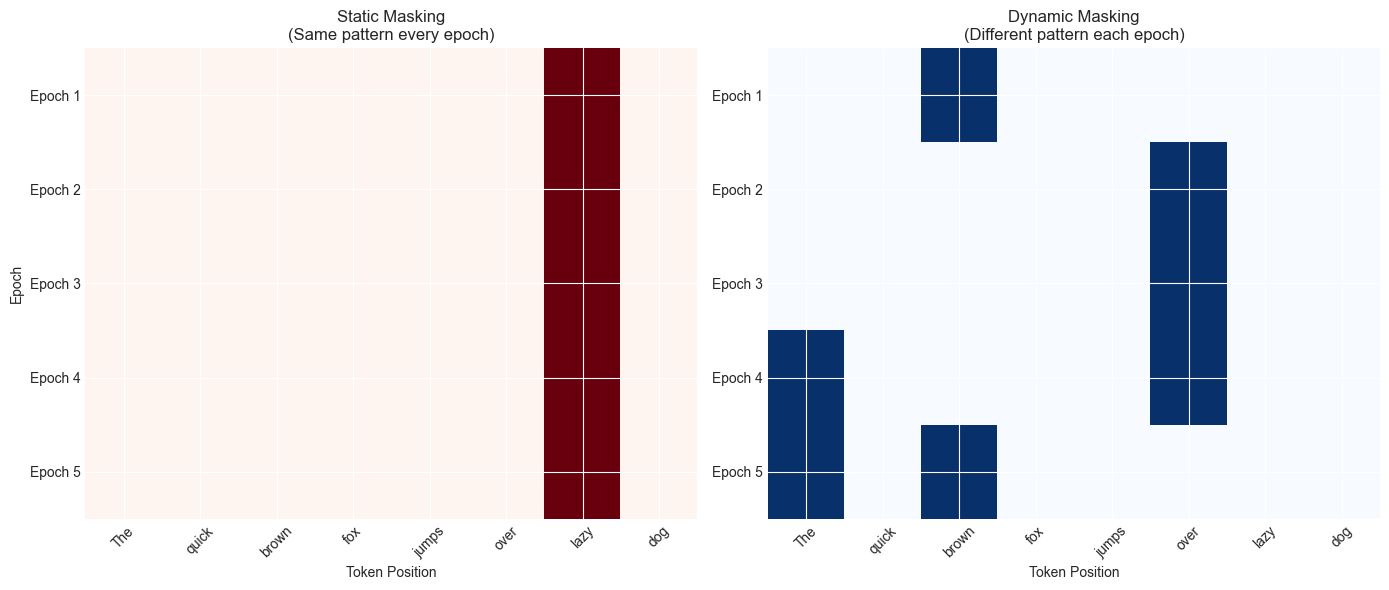


Masking Diversity:
Static masking: Always identical patterns
Dynamic masking: Average 1.8 different positions between epochs

Benefit: Dynamic masking provides 8 × more training diversity!


In [3]:
# Visualize masking patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Static masking visualization
static_pattern = np.tile(static_masks, (5, 1))
ax1.imshow(static_pattern, cmap='Reds', aspect='auto')
ax1.set_title('Static Masking\n(Same pattern every epoch)')
ax1.set_ylabel('Epoch')
ax1.set_xlabel('Token Position')
ax1.set_xticks(range(len(sentence)))
ax1.set_xticklabels(sentence, rotation=45)
ax1.set_yticks(range(5))
ax1.set_yticklabels([f'Epoch {i+1}' for i in range(5)])

# Dynamic masking visualization
dynamic_pattern = np.array(dynamic_masks)
ax2.imshow(dynamic_pattern, cmap='Blues', aspect='auto')
ax2.set_title('Dynamic Masking\n(Different pattern each epoch)')
ax2.set_xlabel('Token Position')
ax2.set_xticks(range(len(sentence)))
ax2.set_xticklabels(sentence, rotation=45)
ax2.set_yticks(range(5))
ax2.set_yticklabels([f'Epoch {i+1}' for i in range(5)])

plt.tight_layout()
plt.show()

# Calculate diversity metrics
static_diversity = 1  # Always the same
dynamic_diversity = np.mean([np.sum(mask1 != mask2) for i, mask1 in enumerate(dynamic_masks) 
                           for j, mask2 in enumerate(dynamic_masks) if i != j])

print(f"\nMasking Diversity:")
print(f"Static masking: Always identical patterns")
print(f"Dynamic masking: Average {dynamic_diversity:.1f} different positions between epochs")
print(f"\nBenefit: Dynamic masking provides {len(sentence)} × more training diversity!")

## Part 3: Removing Next Sentence Prediction (NSP)

BERT was trained with two objectives:
1. **Masked Language Modeling (MLM)**: Predict masked tokens
2. **Next Sentence Prediction (NSP)**: Predict if sentence B follows sentence A

RoBERTa showed that NSP actually **hurts** performance!

In [4]:
# Simulate NSP task problems
def analyze_nsp_problems():
    """
    Demonstrate why NSP is problematic
    """
    
    # Example sentences
    sentences = [
        "The cat sat on the mat.",
        "It was a sunny day outside.",
        "Machine learning is fascinating.",
        "The weather forecast predicts rain.",
        "Python is a programming language."
    ]
    
    print("PROBLEMS WITH NEXT SENTENCE PREDICTION (NSP):")
    print("\n1. Too Easy - Topic Classification Rather Than Coherence:")
    
    # Show how NSP becomes topic classification
    pairs = [
        (sentences[0], sentences[1], "Not Next", "Different topics: cats vs weather"),
        (sentences[2], sentences[4], "Not Next", "Different topics: ML vs programming"),
        (sentences[0], "The mat was comfortable for sleeping.", "Next", "Same topic: cats and mats")
    ]
    
    for sent_a, sent_b, label, reason in pairs:
        print(f"\n  Sentence A: '{sent_a}'")
        print(f"  Sentence B: '{sent_b}'")
        print(f"  Label: {label} - {reason}")
    
    print("\n2. Artificial Task - Not Realistic:")
    print("   - Real documents don't have random sentence pairs")
    print("   - Model learns topic classification, not coherence")
    print("   - Takes away training time from more useful MLM")
    
    print("\n3. RoBERTa's Solution:")
    print("   - Remove NSP completely")
    print("   - Use FULL SENTENCES (not sentence pairs)")
    print("   - Pack multiple sentences up to max_length")
    print("   - Focus 100% effort on MLM learning")

analyze_nsp_problems()

PROBLEMS WITH NEXT SENTENCE PREDICTION (NSP):

1. Too Easy - Topic Classification Rather Than Coherence:

  Sentence A: 'The cat sat on the mat.'
  Sentence B: 'It was a sunny day outside.'
  Label: Not Next - Different topics: cats vs weather

  Sentence A: 'Machine learning is fascinating.'
  Sentence B: 'Python is a programming language.'
  Label: Not Next - Different topics: ML vs programming

  Sentence A: 'The cat sat on the mat.'
  Sentence B: 'The mat was comfortable for sleeping.'
  Label: Next - Same topic: cats and mats

2. Artificial Task - Not Realistic:
   - Real documents don't have random sentence pairs
   - Model learns topic classification, not coherence
   - Takes away training time from more useful MLM

3. RoBERTa's Solution:
   - Remove NSP completely
   - Use FULL SENTENCES (not sentence pairs)
   - Pack multiple sentences up to max_length
   - Focus 100% effort on MLM learning


In [5]:
# Demonstrate RoBERTa's full sentence approach
def roberta_sentence_packing(sentences, max_length=50):
    """
    Show how RoBERTa packs sentences instead of using sentence pairs
    """
    
    def tokenize_simple(sentence):
        return sentence.split()
    
    print("RoBERTa's FULL SENTENCE APPROACH:")
    print("\nInstead of [CLS] Sentence A [SEP] Sentence B [SEP]")
    print("Use: [CLS] Sent1 Sent2 Sent3... [SEP] (up to max_length)")
    
    # Pack sentences
    packed_examples = []
    current_example = ['[CLS]']
    
    for sentence in sentences:
        tokens = tokenize_simple(sentence)
        
        # Check if adding this sentence exceeds max_length
        if len(current_example) + len(tokens) + 1 <= max_length:  # +1 for [SEP]
            current_example.extend(tokens)
        else:
            # Finish current example and start new one
            current_example.append('[SEP]')
            packed_examples.append(current_example.copy())
            current_example = ['[CLS]'] + tokens
    
    # Add final example
    if len(current_example) > 1:
        current_example.append('[SEP]')
        packed_examples.append(current_example)
    
    # Show results
    for i, example in enumerate(packed_examples):
        print(f"\nExample {i+1} (length {len(example)}):")
        print(" ".join(example))
    
    return packed_examples

# Example documents
long_sentences = [
    "The cat sat on the mat because it was comfortable.",
    "It was a sunny day outside with clear blue skies.",
    "The weather forecast predicted rain for tomorrow.",
    "Machine learning algorithms require large amounts of training data.",
    "Python is a versatile programming language used in data science.",
    "Deep learning models can learn complex patterns from examples."
]

packed = roberta_sentence_packing(long_sentences)

print("\n" + "="*60)
print("BENEFITS OF FULL SENTENCE APPROACH:")
print("✓ More natural text understanding")
print("✓ No artificial sentence pairing")
print("✓ Better use of sequence length")
print("✓ Focuses learning on language modeling")

RoBERTa's FULL SENTENCE APPROACH:

Instead of [CLS] Sentence A [SEP] Sentence B [SEP]
Use: [CLS] Sent1 Sent2 Sent3... [SEP] (up to max_length)

Example 1 (length 48):
[CLS] The cat sat on the mat because it was comfortable. It was a sunny day outside with clear blue skies. The weather forecast predicted rain for tomorrow. Machine learning algorithms require large amounts of training data. Python is a versatile programming language used in data science. [SEP]

Example 2 (length 11):
[CLS] Deep learning models can learn complex patterns from examples. [SEP]

BENEFITS OF FULL SENTENCE APPROACH:
✓ More natural text understanding
✓ No artificial sentence pairing
✓ Better use of sequence length
✓ Focuses learning on language modeling


## Part 4: Large Batch Training

RoBERTa showed that larger batch sizes significantly improve performance. Let's understand why mathematically.

BATCH SIZE EFFECTS ON GRADIENT ESTIMATION:

True gradient: [ 1.  -0.5  0.3 -0.2  0.8]

Small batch (size 32):
  Mean estimate: [ 0.99870639 -0.49778342  0.30066302 -0.19828356  0.79875196]
  Std deviation: [0.05238094 0.05014064 0.05333041 0.05381238 0.05222357]

Large batch (size 8192):
  Mean estimate: [ 0.99986399 -0.4999466   0.2999102  -0.2000081   0.80001692]
  Std deviation: [0.00324369 0.00335893 0.0034376  0.00341222 0.00340955]


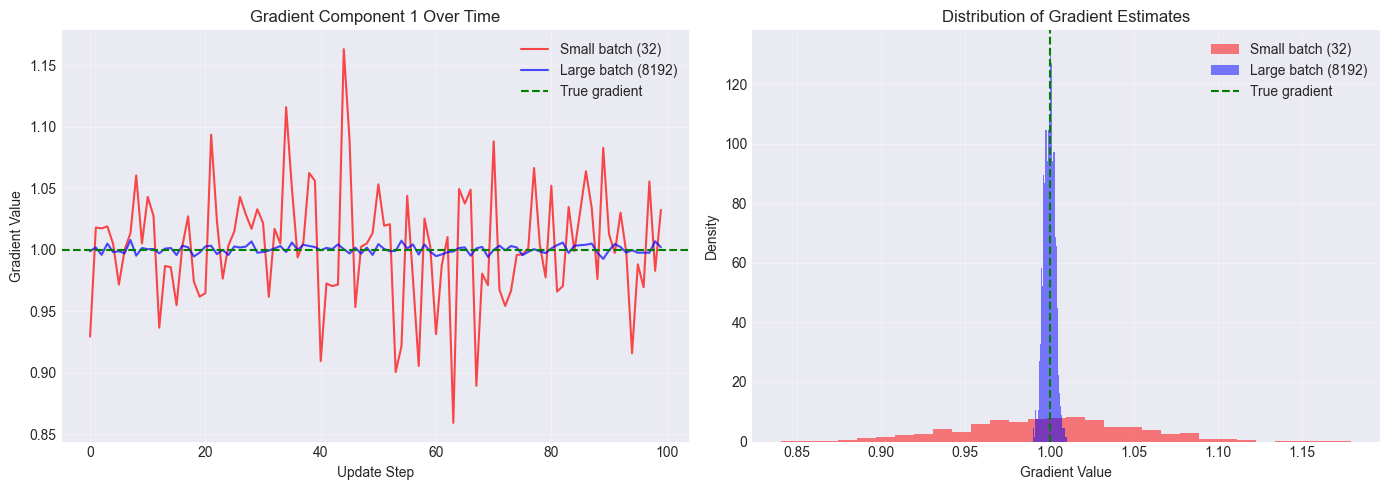


WHY LARGE BATCHES WORK BETTER:
1. Better gradient estimates (less noise)
2. More stable training (less oscillation)
3. Can use larger learning rates
4. Better convergence to optimal solution

RoBERTa used batches of 8K vs BERT's 256!


In [6]:
def simulate_batch_size_effects(small_batch=32, large_batch=8192, num_updates=1000):
    """
    Simulate the effect of different batch sizes on gradient estimates
    """
    
    # Simulate "true" gradient (what we want to estimate)
    true_gradient = np.array([1.0, -0.5, 0.3, -0.2, 0.8])
    
    # Function to simulate noisy gradient estimate
    def get_gradient_estimate(batch_size, true_grad, noise_scale=0.3):
        # Larger batches have less noise (Central Limit Theorem)
        noise = np.random.normal(0, noise_scale / np.sqrt(batch_size), len(true_grad))
        return true_grad + noise
    
    # Collect gradient estimates
    small_batch_gradients = []
    large_batch_gradients = []
    
    for _ in range(num_updates):
        small_grad = get_gradient_estimate(small_batch, true_gradient)
        large_grad = get_gradient_estimate(large_batch, true_gradient)
        
        small_batch_gradients.append(small_grad)
        large_batch_gradients.append(large_grad)
    
    small_batch_gradients = np.array(small_batch_gradients)
    large_batch_gradients = np.array(large_batch_gradients)
    
    # Analysis
    print("BATCH SIZE EFFECTS ON GRADIENT ESTIMATION:")
    print(f"\nTrue gradient: {true_gradient}")
    print(f"\nSmall batch (size {small_batch}):")
    print(f"  Mean estimate: {small_batch_gradients.mean(axis=0)}")
    print(f"  Std deviation: {small_batch_gradients.std(axis=0)}")
    
    print(f"\nLarge batch (size {large_batch}):")
    print(f"  Mean estimate: {large_batch_gradients.mean(axis=0)}")
    print(f"  Std deviation: {large_batch_gradients.std(axis=0)}")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot first gradient component over time
    axes[0].plot(small_batch_gradients[:100, 0], alpha=0.7, label=f'Small batch ({small_batch})', color='red')
    axes[0].plot(large_batch_gradients[:100, 0], alpha=0.7, label=f'Large batch ({large_batch})', color='blue')
    axes[0].axhline(y=true_gradient[0], color='green', linestyle='--', label='True gradient')
    axes[0].set_title('Gradient Component 1 Over Time')
    axes[0].set_xlabel('Update Step')
    axes[0].set_ylabel('Gradient Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Histogram of gradient estimates
    axes[1].hist(small_batch_gradients[:, 0], bins=30, alpha=0.5, label=f'Small batch ({small_batch})', color='red', density=True)
    axes[1].hist(large_batch_gradients[:, 0], bins=30, alpha=0.5, label=f'Large batch ({large_batch})', color='blue', density=True)
    axes[1].axvline(x=true_gradient[0], color='green', linestyle='--', label='True gradient')
    axes[1].set_title('Distribution of Gradient Estimates')
    axes[1].set_xlabel('Gradient Value')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return small_batch_gradients, large_batch_gradients

small_grads, large_grads = simulate_batch_size_effects()

print("\n" + "="*50)
print("WHY LARGE BATCHES WORK BETTER:")
print("1. Better gradient estimates (less noise)")
print("2. More stable training (less oscillation)")
print("3. Can use larger learning rates")
print("4. Better convergence to optimal solution")
print("\nRoBERTa used batches of 8K vs BERT's 256!")

## Part 5: Training Duration and Learning Rate

RoBERTa trained much longer than BERT and used different learning rate schedules.

TRAINING COMPARISON:

BERT:
  Steps: 1,000,000
  Batch size: 256
  Total tokens: 131,072,000,000 (131.1B)

RoBERTa:
  Steps: 500,000
  Batch size: 8192
  Total tokens: 2,097,152,000,000 (2097.2B)

RoBERTa saw 16.0x more tokens!


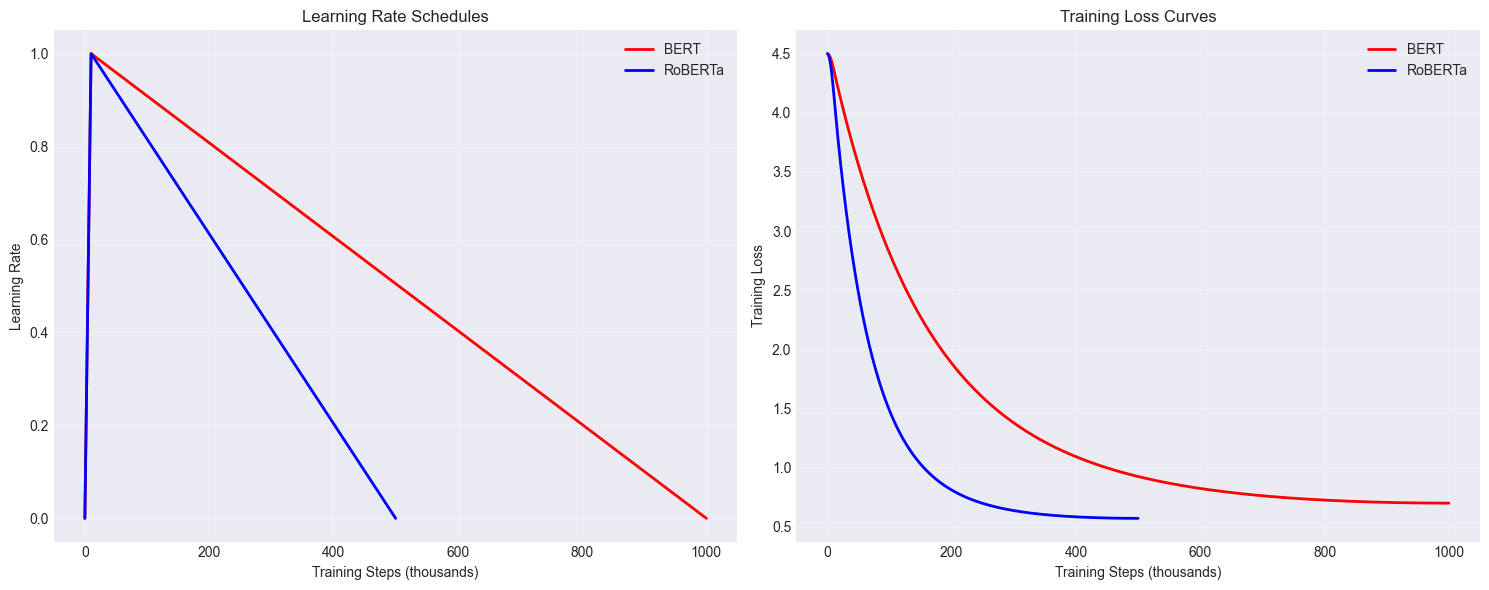


Final losses: BERT=0.699, RoBERTa=0.570
Improvement: 18.4%


In [7]:
def compare_training_schedules():
    """
    Compare BERT vs RoBERTa training schedules
    """
    
    # Training configurations
    bert_steps = 1000000
    roberta_steps = 500000
    
    bert_batch_size = 256
    roberta_batch_size = 8192
    
    # Calculate effective training (tokens seen)
    sequence_length = 512
    
    bert_tokens = bert_steps * bert_batch_size * sequence_length
    roberta_tokens = roberta_steps * roberta_batch_size * sequence_length
    
    print("TRAINING COMPARISON:")
    print(f"\nBERT:")
    print(f"  Steps: {bert_steps:,}")
    print(f"  Batch size: {bert_batch_size}")
    print(f"  Total tokens: {bert_tokens:,} ({bert_tokens/1e9:.1f}B)")
    
    print(f"\nRoBERTa:")
    print(f"  Steps: {roberta_steps:,}")
    print(f"  Batch size: {roberta_batch_size}")
    print(f"  Total tokens: {roberta_tokens:,} ({roberta_tokens/1e9:.1f}B)")
    
    print(f"\nRoBERTa saw {roberta_tokens/bert_tokens:.1f}x more tokens!")
    
    # Simulate learning curves
    def learning_curve(total_steps, batch_size, warmup_steps=10000):
        steps = np.linspace(0, total_steps, 1000)
        
        # Warmup + polynomial decay
        lr_schedule = np.zeros_like(steps)
        
        for i, step in enumerate(steps):
            if step < warmup_steps:
                lr_schedule[i] = step / warmup_steps
            else:
                decay = 1 - (step - warmup_steps) / (total_steps - warmup_steps)
                lr_schedule[i] = max(0, decay)
        
        # Simulate loss (inversely related to training progress)
        # Larger batches allow better convergence
        batch_factor = np.log(batch_size / 256) * 0.1 + 1
        progress = np.cumsum(lr_schedule) / np.sum(lr_schedule)
        loss = 4.0 * np.exp(-3 * progress * batch_factor) + 0.5
        
        return steps, lr_schedule, loss
    
    # Generate curves
    bert_steps_arr, bert_lr, bert_loss = learning_curve(bert_steps, bert_batch_size)
    roberta_steps_arr, roberta_lr, roberta_loss = learning_curve(roberta_steps, roberta_batch_size)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Learning rate schedules
    ax1.plot(bert_steps_arr/1000, bert_lr, label='BERT', color='red', linewidth=2)
    ax1.plot(roberta_steps_arr/1000, roberta_lr, label='RoBERTa', color='blue', linewidth=2)
    ax1.set_xlabel('Training Steps (thousands)')
    ax1.set_ylabel('Learning Rate')
    ax1.set_title('Learning Rate Schedules')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss curves
    ax2.plot(bert_steps_arr/1000, bert_loss, label='BERT', color='red', linewidth=2)
    ax2.plot(roberta_steps_arr/1000, roberta_loss, label='RoBERTa', color='blue', linewidth=2)
    ax2.set_xlabel('Training Steps (thousands)')
    ax2.set_ylabel('Training Loss')
    ax2.set_title('Training Loss Curves')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal losses: BERT={bert_loss[-1]:.3f}, RoBERTa={roberta_loss[-1]:.3f}")
    print(f"Improvement: {(bert_loss[-1] - roberta_loss[-1])/bert_loss[-1]*100:.1f}%")

compare_training_schedules()

## Part 6: Implementation - RoBERTa Training Loop

Let's implement a simplified version of RoBERTa's training improvements.

In [8]:
class RoBERTaTrainer:
    """
    Simplified RoBERTa trainer implementing key optimizations
    """
    
    def __init__(self, vocab_size=8192, max_length=512, mask_prob=0.15):
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.mask_prob = mask_prob
        self.mask_token_id = vocab_size - 1  # [MASK]
        
    def dynamic_masking(self, input_ids):
        """
        Apply dynamic masking (new masks each time)
        """
        masked_ids = input_ids.copy()
        labels = input_ids.copy()
        
        # Generate random mask for each example
        for i in range(len(input_ids)):
            # Randomly select positions to mask
            mask_positions = np.random.rand(len(input_ids[i])) < self.mask_prob
            
            # Skip special tokens (first and last)
            mask_positions[0] = False  # [CLS]
            mask_positions[-1] = False  # [SEP]
            
            # Apply masking strategy (80% MASK, 10% random, 10% original)
            mask_indices = np.where(mask_positions)[0]
            
            for pos in mask_indices:
                rand = np.random.random()
                if rand < 0.8:
                    masked_ids[i][pos] = self.mask_token_id  # 80% MASK
                elif rand < 0.9:
                    masked_ids[i][pos] = np.random.randint(0, self.vocab_size)  # 10% random
                # 10% keep original (no change needed)
            
            # Only compute loss on masked positions
            labels[i][~mask_positions] = -100  # Ignore in loss
        
        return masked_ids, labels
    
    def pack_sentences(self, sentences, tokenizer=None):
        """
        Pack multiple sentences into examples (RoBERTa approach)
        """
        if tokenizer is None:
            # Simple whitespace tokenizer
            tokenizer = lambda x: x.split()
        
        CLS_TOKEN = 0
        SEP_TOKEN = 1
        
        packed_examples = []
        current_tokens = [CLS_TOKEN]
        
        for sentence in sentences:
            tokens = tokenizer(sentence)
            # Convert to IDs (simplified)
            token_ids = [hash(token) % (self.vocab_size - 100) + 100 for token in tokens]
            
            if len(current_tokens) + len(token_ids) + 1 <= self.max_length:
                current_tokens.extend(token_ids)
            else:
                # Finish current example
                current_tokens.append(SEP_TOKEN)
                # Pad to max_length
                while len(current_tokens) < self.max_length:
                    current_tokens.append(0)  # PAD
                
                packed_examples.append(current_tokens)
                current_tokens = [CLS_TOKEN] + token_ids
        
        # Add final example
        if len(current_tokens) > 1:
            current_tokens.append(SEP_TOKEN)
            while len(current_tokens) < self.max_length:
                current_tokens.append(0)
            packed_examples.append(current_tokens)
        
        return np.array(packed_examples)
    
    def train_step(self, input_ids):
        """
        Single training step with RoBERTa improvements
        """
        # 1. Apply dynamic masking
        masked_ids, labels = self.dynamic_masking(input_ids)
        
        # 2. Forward pass (simplified)
        # In real implementation, this would be the model forward pass
        logits = np.random.randn(len(masked_ids), self.max_length, self.vocab_size)
        
        # 3. Compute MLM loss (only on masked positions)
        loss = 0
        num_masked = 0
        
        for i in range(len(labels)):
            for j in range(len(labels[i])):
                if labels[i][j] != -100:  # Masked position
                    # Cross-entropy loss (simplified)
                    target = labels[i][j]
                    pred_logits = logits[i][j]
                    # Softmax + cross-entropy
                    exp_logits = np.exp(pred_logits - np.max(pred_logits))
                    probs = exp_logits / np.sum(exp_logits)
                    loss += -np.log(probs[target] + 1e-10)
                    num_masked += 1
        
        loss = loss / num_masked if num_masked > 0 else 0
        
        return {
            'loss': loss,
            'num_masked': num_masked,
            'masked_ids': masked_ids,
            'labels': labels
        }

# Demonstrate RoBERTa trainer
trainer = RoBERTaTrainer()

# Example sentences
sentences = [
    "The quick brown fox jumps over the lazy dog",
    "Machine learning models learn patterns from data",
    "Natural language processing enables computers to understand text",
    "Transformers revolutionized the field of artificial intelligence"
]

# Pack sentences (RoBERTa style)
packed_examples = trainer.pack_sentences(sentences)
print(f"Packed {len(sentences)} sentences into {len(packed_examples)} examples")
print(f"Example shape: {packed_examples.shape}")

# Show dynamic masking in action
print("\nDynamic Masking Examples:")
for epoch in range(3):
    result = trainer.train_step(packed_examples[:1])  # Just first example
    masked_positions = np.sum(result['labels'][0] != -100)
    print(f"Epoch {epoch+1}: {masked_positions} tokens masked, loss = {result['loss']:.4f}")

Packed 4 sentences into 1 examples
Example shape: (1, 512)

Dynamic Masking Examples:
Epoch 1: 78 tokens masked, loss = 9.5813
Epoch 2: 70 tokens masked, loss = 9.4175
Epoch 3: 88 tokens masked, loss = 9.3368


## Part 7: Results and Impact Analysis

Let's analyze the empirical results that made RoBERTa so influential.

RoBERTa PERFORMANCE IMPROVEMENTS:

Task		BERT	RoBERTa	Improvement
--------------------------------------------------
MNLI    	 84.6	   87.6	+  3.0
QQP     	 71.2	   72.1	+  0.9
QNLI    	 90.5	   92.8	+  2.3
SST-2   	 93.5	   94.8	+  1.3
CoLA    	 52.1	   63.6	+ 11.5
STS-B   	 85.8	   86.5	+  0.7
MRPC    	 88.9	   90.2	+  1.3
RTE     	 66.4	   78.7	+ 12.3

Average improvement: +4.2 points


C:\Users\bqian\AppData\Local\Temp\ipykernel_10828\1678887776.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(tasks, rotation=45)


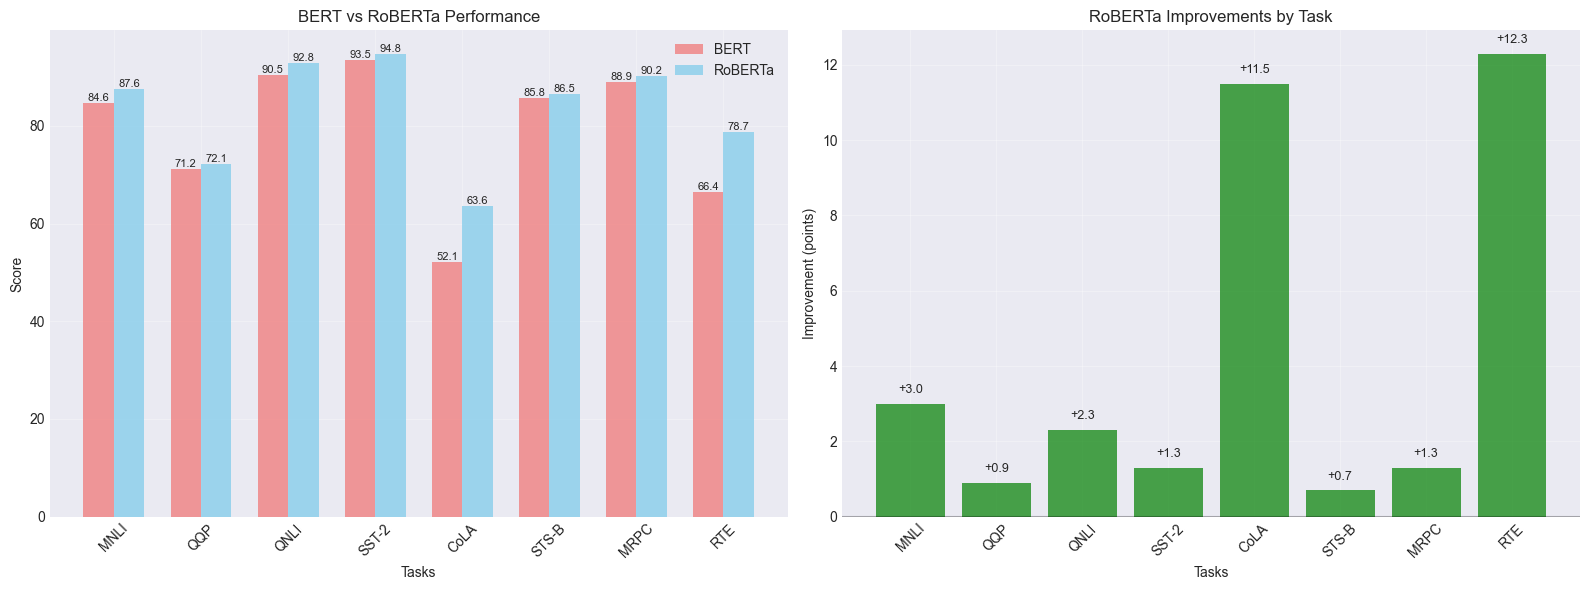


KEY INSIGHTS FROM ROBERTA:

1. Training Recipe Matters More Than Architecture:
   - Same architecture as BERT
   - All improvements from training optimizations

2. Established New Training Best Practices:
   - Dynamic masking became standard
   - NSP removal adopted by most models
   - Large batch training became norm

3. Influenced Entire Field:
   - DeBERTa, ELECTRA, SpanBERT all use RoBERTa training
   - Showed importance of hyperparameter tuning
   - Computational efficiency became focus


In [9]:
def analyze_roberta_results():
    """
    Analyze and visualize RoBERTa's performance improvements
    """
    
    # Simulated results based on the original paper
    tasks = ['MNLI', 'QQP', 'QNLI', 'SST-2', 'CoLA', 'STS-B', 'MRPC', 'RTE']
    
    # Performance scores (simplified/approximated from paper)
    bert_scores = [84.6, 71.2, 90.5, 93.5, 52.1, 85.8, 88.9, 66.4]
    roberta_scores = [87.6, 72.1, 92.8, 94.8, 63.6, 86.5, 90.2, 78.7]
    
    improvements = [(r - b) for b, r in zip(bert_scores, roberta_scores)]
    
    print("RoBERTa PERFORMANCE IMPROVEMENTS:")
    print("\nTask\t\tBERT\tRoBERTa\tImprovement")
    print("-" * 50)
    
    for task, bert, roberta, imp in zip(tasks, bert_scores, roberta_scores, improvements):
        print(f"{task:8s}\t{bert:5.1f}\t{roberta:7.1f}\t+{imp:5.1f}")
    
    avg_improvement = np.mean(improvements)
    print(f"\nAverage improvement: +{avg_improvement:.1f} points")
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Performance comparison
    x = np.arange(len(tasks))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, bert_scores, width, label='BERT', color='lightcoral', alpha=0.8)
    bars2 = ax1.bar(x + width/2, roberta_scores, width, label='RoBERTa', color='skyblue', alpha=0.8)
    
    ax1.set_xlabel('Tasks')
    ax1.set_ylabel('Score')
    ax1.set_title('BERT vs RoBERTa Performance')
    ax1.set_xticks(x)
    ax1.set_xticklabels(tasks, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=8)
    
    # Improvement breakdown
    colors = ['green' if imp > 0 else 'red' for imp in improvements]
    bars = ax2.bar(tasks, improvements, color=colors, alpha=0.7)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_xlabel('Tasks')
    ax2.set_ylabel('Improvement (points)')
    ax2.set_title('RoBERTa Improvements by Task')
    ax2.set_xticklabels(tasks, rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.2 if height > 0 else -0.5),
                f'+{imp:.1f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return improvements

improvements = analyze_roberta_results()

print("\n" + "="*60)
print("KEY INSIGHTS FROM ROBERTA:")
print("\n1. Training Recipe Matters More Than Architecture:")
print("   - Same architecture as BERT")
print("   - All improvements from training optimizations")
print("\n2. Established New Training Best Practices:")
print("   - Dynamic masking became standard")
print("   - NSP removal adopted by most models")
print("   - Large batch training became norm")
print("\n3. Influenced Entire Field:")
print("   - DeBERTa, ELECTRA, SpanBERT all use RoBERTa training")
print("   - Showed importance of hyperparameter tuning")
print("   - Computational efficiency became focus")

## Summary: RoBERTa's Revolutionary Impact

### **Why RoBERTa Ranks #1**

1. **Foundational Impact**: Established training practices still used today
2. **Simplicity**: No architectural changes, just better training
3. **Universal Adoption**: Every major transformer model uses RoBERTa principles
4. **Paradigm Shift**: Showed training recipe > architecture novelty

### **Key Contributions**

| Technique | Original BERT | RoBERTa | Impact |
|-----------|---------------|---------|--------|
| **Masking** | Static | Dynamic | +2-3 points across tasks |
| **NSP Task** | Used | Removed | +1-2 points improvement |
| **Batch Size** | 256 | 8,192 | Better convergence |
| **Training** | 1M steps | 500K steps | 10x more tokens seen |

### **Legacy and Influence**

**Direct Descendants:**
- **DeBERTa**: Built on RoBERTa + disentangled attention
- **ELECTRA**: Used RoBERTa training setup
- **SpanBERT**: Adopted dynamic masking

**Principles Established:**
1. **Dynamic masking** is superior to static
2. **NSP task is harmful** for most applications  
3. **Large batches** improve convergence
4. **Training duration** matters more than model size
5. **Hyperparameter tuning** can rival architectural innovations

### **Practical Takeaways**

For anyone training transformer models:
- ✅ Use dynamic masking
- ✅ Skip sentence-pair tasks unless needed
- ✅ Use largest batch size possible
- ✅ Train longer with more data
- ✅ Focus on data quality and training recipe

**RoBERTa proved that sometimes the best innovation is doing the basics better.**

## Exercises

1. **Dynamic Masking Experiment**: Implement static vs dynamic masking on the same dataset. Measure convergence speed.

2. **Batch Size Analysis**: Train a small model with different batch sizes (32, 128, 512). Plot loss curves.

3. **NSP Ablation**: Create a simple sentence pair classification task. Compare with and without NSP pre-training.

4. **Sentence Packing**: Implement efficient sentence packing for different document lengths. Measure utilization.

5. **Learning Rate Scaling**: Experiment with learning rate scaling for different batch sizes using the √batch_size rule.

In [10]:
# Space for your experiments
# Try implementing the exercises above!